# SpatialMouse - Deconvolve xDbit Kidney section using cell2location

- Followed this tutorial: https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html
- More updated tutorial here: https://github.com/BayraktarLab/cell2location/blob/master/docs/notebooks/cell2location_tutorial.ipynb

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [36]:
## Import the custom library
import os
import sys

# add xDbit toolbox path to path variable
module_path = os.path.abspath("../../")
if module_path not in sys.path:
    sys.path.append(module_path)

import xdbit_funcs as db

import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
import seaborn as sns
import scvi
import cell2location

In [3]:
plt.rcParams['figure.dpi'] = 80
plt.style.use('default')

## Set results directory

In [4]:
data_dir = "out"
results_folder = os.path.join(data_dir, "deconvolution")

# create model path if necessary
Path(results_folder).mkdir(parents=True, exist_ok=True)

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = os.path.join(results_folder, 'reference_signatures')
run_name = os.path.join(results_folder, 'cell2location_map')

# Load data

## Generate single-cell dataset

The dataset from this publication was used: https://www.nature.com/articles/s41467-021-22266-1 <br>
Dataset was downloaded from: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE157079

### Load raw single-cell data

In [5]:
# count matrix file
sc_file = "/lustre/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_counts.csv"

# load metadata
clusters = pd.read_csv("/lustre/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_clusters.txt.gz", 
                       sep="\t", usecols=["barcodes", "clusters"]).set_index("barcodes")
umap = pd.read_csv("/lustre/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_umap.txt.gz", 
                       sep="\t", index_col=0)
pheno = pd.read_csv("/lustre/home/hpc/johannes.wirth/data/datasets/MouseKidneyCellAtlas/GSE157079_P0_adult_pheno.txt.gz", 
                       sep="\t", usecols=['barcodes', 'pheno']).set_index("barcodes")

In [6]:
# load matrix
scadata = sc.read_text(sc_file, delimiter=",").transpose()

# add metadata
scadata.obs["celltype"] = clusters
scadata.obs[["UMAP1", "UMAP2"]] = umap
scadata.obsm["X_umap"] = scadata.obs[["UMAP1", "UMAP2"]].values
scadata.obs["pheno"] = pheno

In [7]:
scadata

AnnData object with n_obs × n_vars = 43636 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    obsm: 'X_umap'

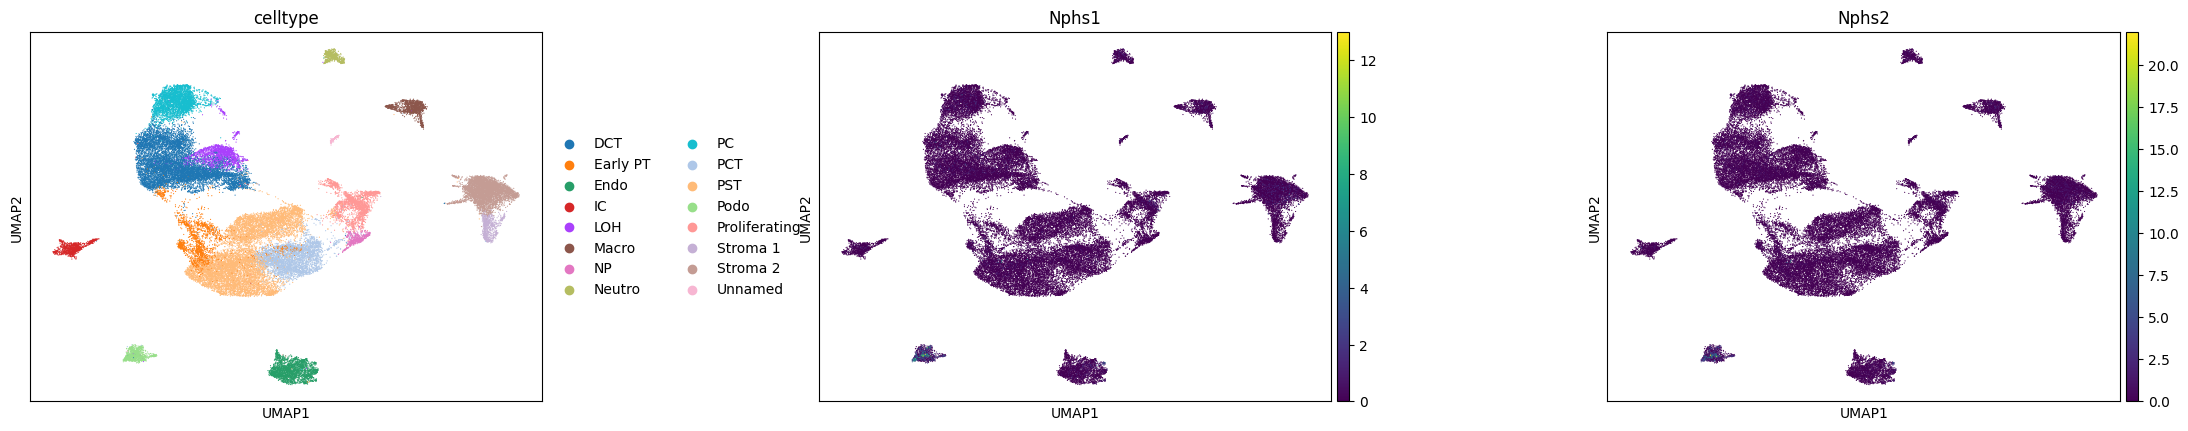

In [8]:
sc.pl.umap(scadata, color=["celltype", "Nphs1", "Nphs2"], wspace=0.4)

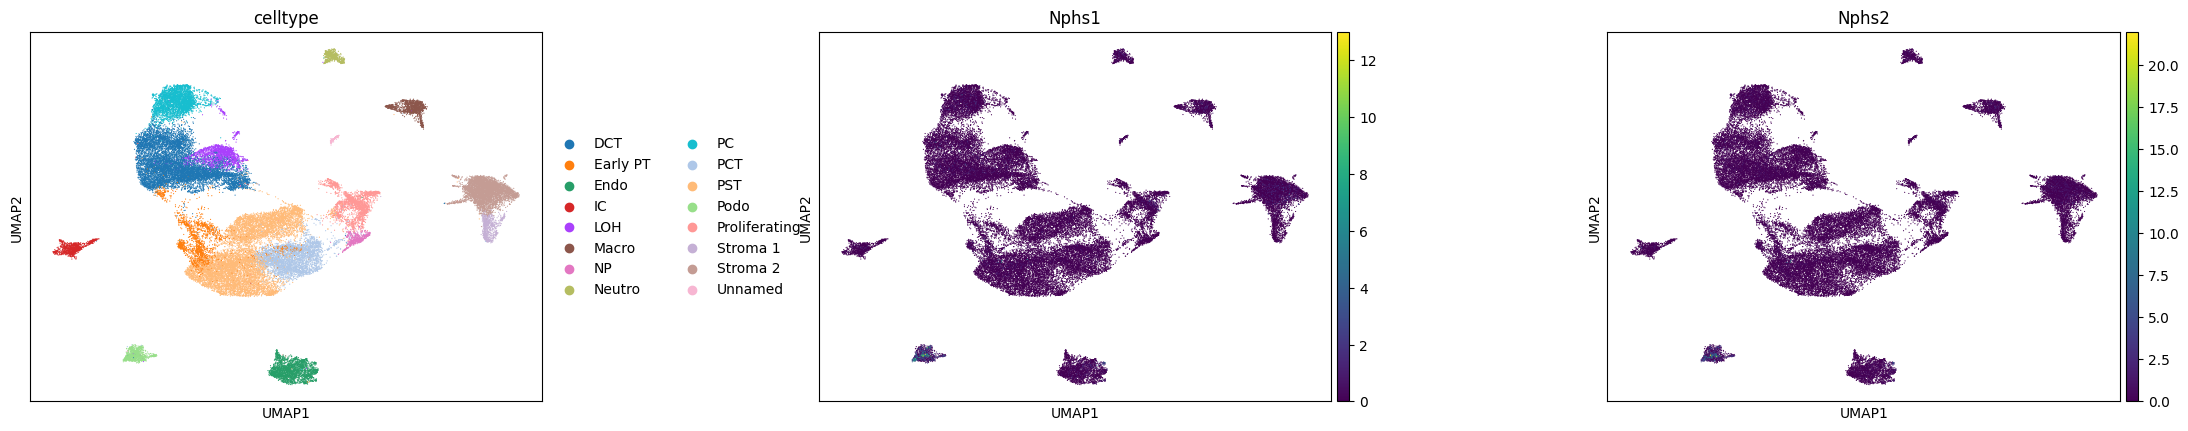

In [9]:
sc.pl.umap(scadata, color=["celltype", "Nphs1", "Nphs2"], wspace=0.4)

### Save resulting dataset

In [10]:
adatafile = os.path.join(data_dir, "GSE157079_P0_adult.h5ad")

In [11]:
scadata.write(adatafile)

### Reload dataset

In [12]:
scadata = sc.read(adatafile)

### Preprocessing

In [13]:
scadata = db.tl.standard_preprocessing(scadata, dim_reduction=False) # preprocessing without dimensionality reduction to keep UMAP from publication

Store raw counts in adata.layers['counts']...
Normalization, log-transformation...
Calculate highly-variable genes across all samples using seurat flavor...


In [14]:
scadata

AnnData object with n_obs × n_vars = 43636 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'norm_counts'

### Save preprocessed data

In [15]:
pp_file = os.path.join(data_dir, "GSE157079_P0_adult_pp.h5ad")

In [16]:
scadata.write(pp_file)

### Reload preprocessed data

In [17]:
scadata = sc.read(pp_file)

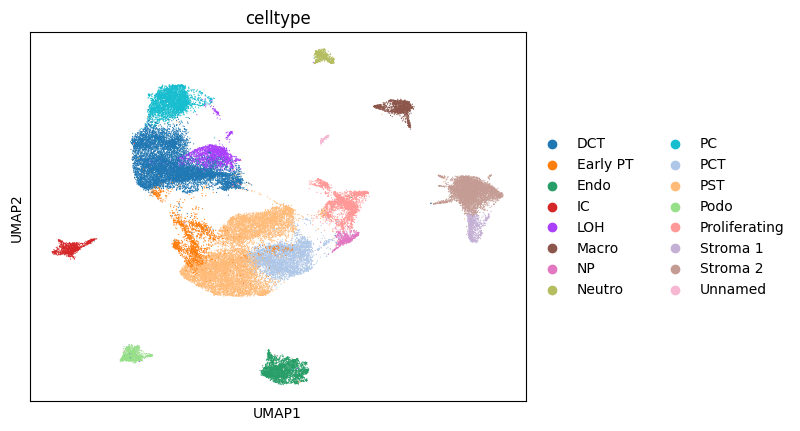

In [18]:
sc.pl.umap(scadata, color=["celltype"], wspace=0.4)

### Select only adult dataset and save again

Since our spatial data is from 3 months old mice we use here the adult dataset only.

In [19]:
# select adult dataset
scadata = scadata[scadata.obs['pheno'] == 'Adult', :].copy()

In [20]:
scadata

AnnData object with n_obs × n_vars = 18498 × 31053
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'hvg', 'log1p'
    obsm: 'X_umap'
    layers: 'counts', 'norm_counts'

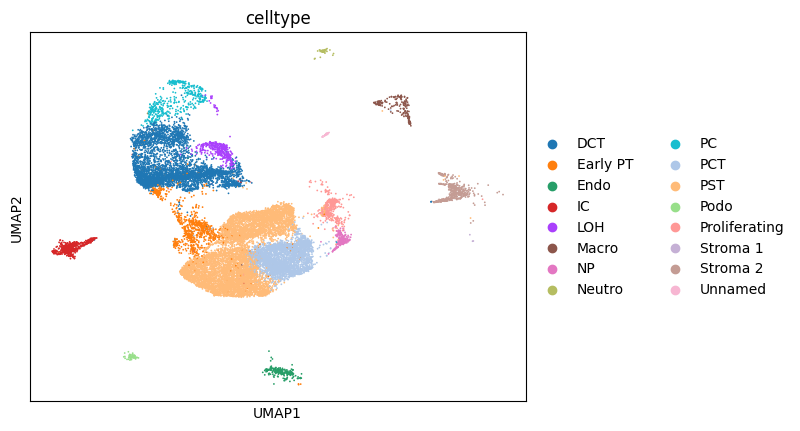

In [21]:
sc.pl.umap(scadata, color=["celltype"])

### Save adult sc dataset

In [22]:
adult_file = os.path.join(data_dir, "GSE157079_adult_pp.h5ad")

In [23]:
scadata.write(adult_file)

### Reload dataset

In [24]:
scadata = sc.read(adult_file)

## Load ST data

In [25]:
st_file = os.path.join(data_dir, "Kidney_adata_pp_wohires_deg.h5ad")

In [26]:
stadata = sc.read(st_file)

In [27]:
stadata

AnnData object with n_obs × n_vars = 4099 × 15027
    obs: 'array_row', 'array_col', 'um_row', 'um_col', 'id', 'pixel_row', 'pixel_col', 'dapi_mean', 'dapi_mean_norm', 'experiment_id', 'organism', 'age', 'organ', 'age_months', 'mouse_id', 'exp_date', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'CT010467.1_pct', 'leiden_uncorrected', 'leiden', 'leiden_coarse'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'deg_leiden', 'deg_leiden_coarse', 'experiment_id_colors', 'hvg', 'id_colors', 'leiden', 'leiden_coarse_colors', 'leiden_colors', 'log1p', 'matchedVis', 'neighbors', 'neighbors_uncorrected', 'organ_colors', 'pca', 'registered', 'spatial', 'tsne', 'umap'
    obsm: 'X_emb', 'X_pca', 'X_scanorama', 'X_tsne', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'norm_counts'
    obsp

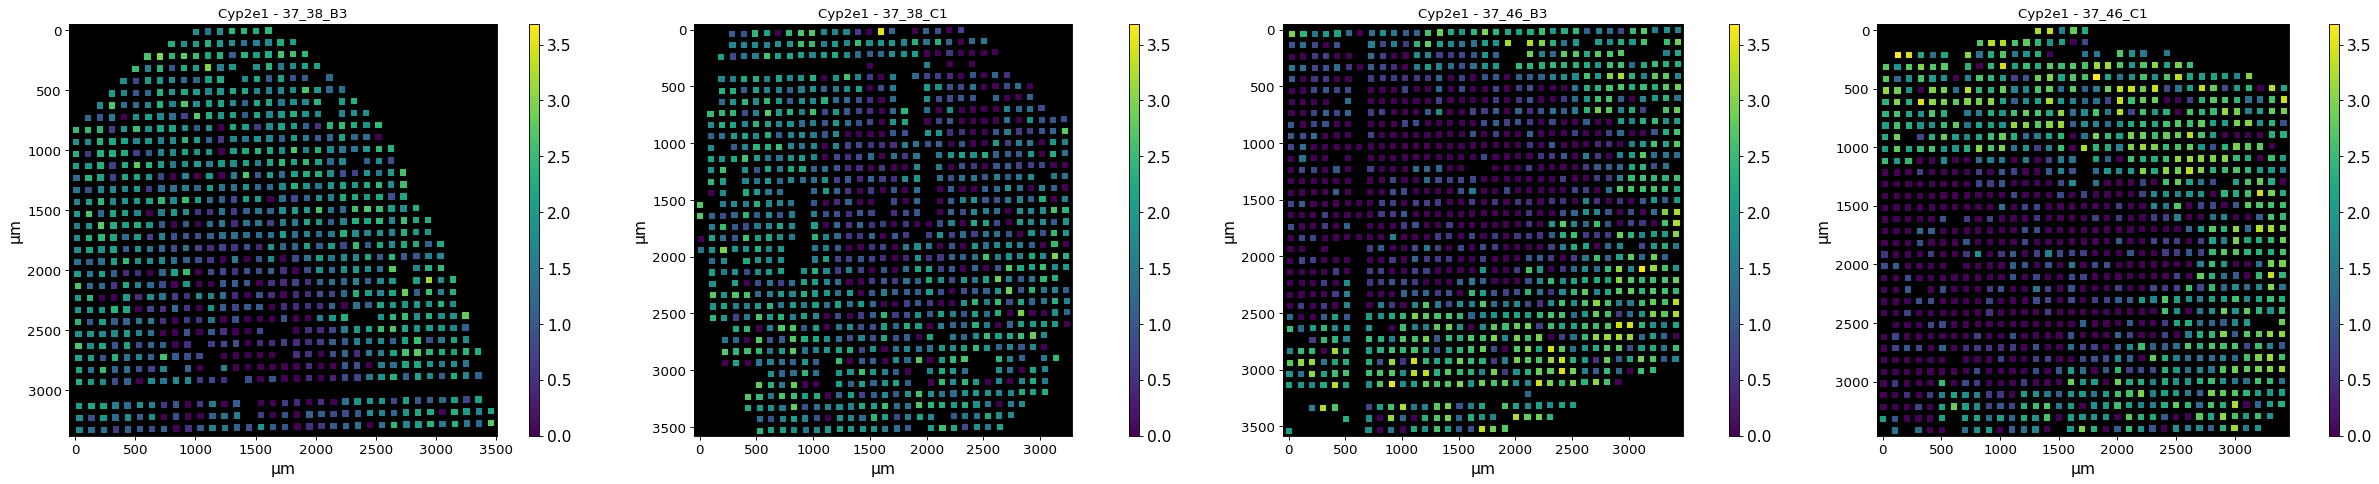

In [28]:
db.pl.spatial(stadata, keys='Cyp2e1', groupby='id')

## Select one section

In figure 4 and 5 we focused on the analysis of the section `37_46_B3`. Here we will do the same.

In [29]:
stadata = db.tl.extract_groups(adata=stadata, groupby='id', groups='37_46_B3')

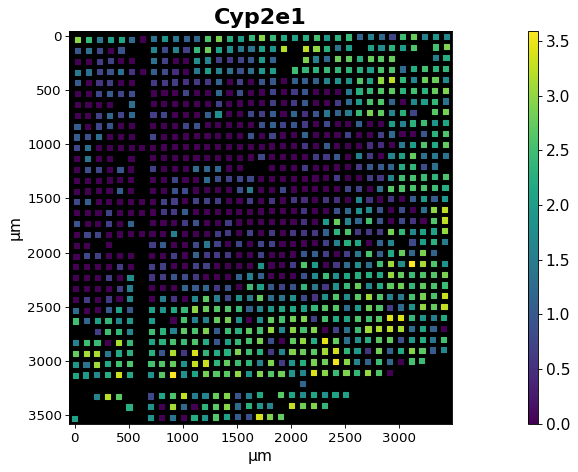

In [30]:
db.pl.spatial(stadata, keys='Cyp2e1', groupby='id')

## Remove mito genes

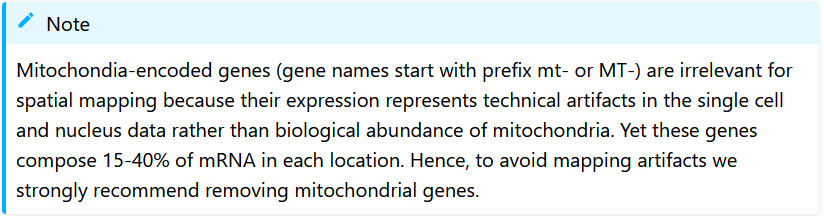
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/cell2location_lymph_node_spatial_tutorial.html

In [31]:
# search for mito genes
scadata.var['mt'] = scadata.var_names.str.contains('MT-', case=False)
stadata.var['mt'] = stadata.var_names.str.contains('MT-', case=False)

In [32]:
# filter out mito genes
scadata = scadata[:, ~scadata.var['mt'].values].copy()
stadata = stadata[:, ~stadata.var['mt'].values].copy()

## Filtering - Cell2location

/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


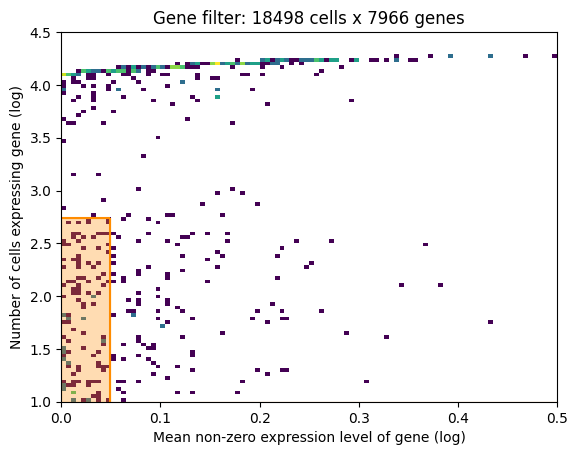

In [33]:
from cell2location.utils.filtering import filter_genes
selected = filter_genes(scadata, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
scadata = scadata[:, selected].copy()

# Deconvolution

## Estimation of reference cell type signatures (NB regression)

## Train model

In [37]:
from cell2location.models import RegressionModel
RegressionModel.setup_anndata(scadata, layer='counts', labels_key='celltype')

In [38]:
sc_model = RegressionModel(scadata)

In [39]:
sc_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': None,
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 18498 │
│          n_vars          │ 7966  │
│         n_batch          │   1   │
│         n_labels         │  16   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

                     labels State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │      DCT      │          0          │
│                       │   Early PT    │          1          │
│                       │     Endo      │          2          │
│                       │      IC       │          3          │
│                       │      LOH      │          4          │
│                       │     Macro     │          5          │
│                       │      NP       │          6          │
│                       │    Neutro     │          7          │
│                       │      PC       │          8          │
│                       │      PCT      │          9          │
│                       │      PST      │         10          │
│                       │     Podo      │         11          │
│                       │ Proliferating │         12          │
│                       │   Stroma 1    │         13          │
│                       │   Stroma 2    │         14          │
│                       │    Unnamed    │         15          │
└───────────────────────┴───────────────┴─────────────────────┘

In [40]:
sc_model.train(max_epochs=250, use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/250:   0%|          | 0/250 [00:00<?, ?it/s]

/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /lustre/groups/hpc/meier_lab/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 250/250: 100%|██████████| 250/250 [03:45<00:00,  1.11it/s, v_num=1, elbo_train=6.73e+7]


### Check if the model needs more training

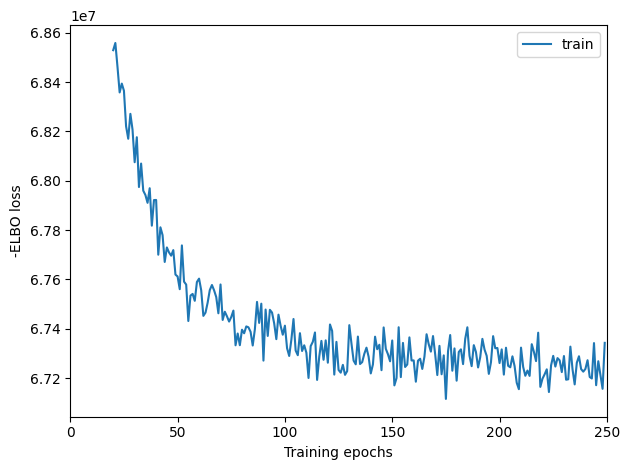

In [41]:
sc_model.plot_history(20)

### Export estimated cell abundance

In [42]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
scadata = sc_model.export_posterior(
    scadata, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
sc_model.save(ref_run_name, overwrite=True)

# Save anndata object with results
adata_file = os.path.join(ref_run_name, "sc.h5ad")
scadata.write(adata_file)
adata_file

Sampling global variables, sample: 100%|██████████| 999/999 [00:09<00:00, 103.91it/s]


'out/deconvolution/reference_signatures/sc.h5ad'

### Examine QC plots

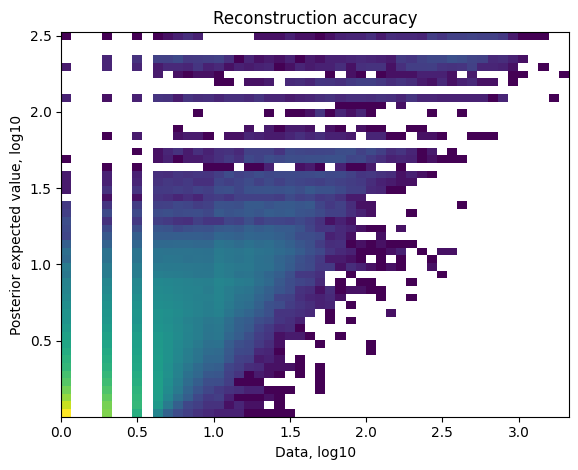

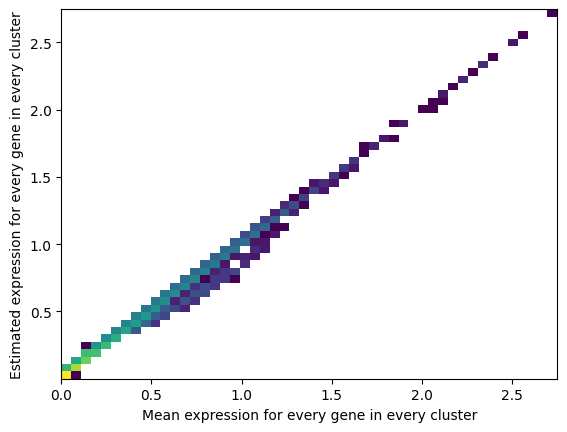

In [43]:
sc_model.plot_QC()

### Reload model and output h5ad

In [44]:
adata_file = os.path.join(ref_run_name, "sc.h5ad")
scadata = sc.read_h5ad(adata_file)
sc_model = cell2location.models.RegressionModel.load(ref_run_name, scadata)

INFO     File out/deconvolution/reference_signatures/model.pt already downloaded             
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/1000:   0%|          | 1/1000 [00:00<04:31,  3.68it/s, v_num=1, elbo_train=6.88e+7]


In [45]:
scadata

AnnData object with n_obs × n_vars = 18498 × 7966
    obs: 'celltype', 'UMAP1', 'UMAP2', 'pheno', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mt', 'n_cells', 'nonz_mean'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'log1p', 'mod'
    obsm: 'X_umap'
    varm: 'means_per_cluster_mu_fg', 'q05_per_cluster_mu_fg', 'q95_per_cluster_mu_fg', 'stds_per_cluster_mu_fg'
    layers: 'counts', 'norm_counts'

### Extract reference cell type signatrues as Dataframe

In [46]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in scadata.varm.keys():
    inf_aver = scadata.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                    for i in scadata.uns['mod']['factor_names']]].copy()
else:
    inf_aver = scadata.var[[f'means_per_cluster_mu_fg_{i}' 
                                    for i in scadata.uns['mod']['factor_names']]].copy()
inf_aver.columns = scadata.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

DCT  Early PT      Endo        IC       LOH
Mrpl15   0.156443  0.249407  0.085298  0.329989  0.154286
Lypla1   0.262455  0.726384  0.105602  0.420419  0.199365
Tcea1    0.178806  0.284363  0.152720  0.422746  0.157286
Atp6v1h  0.189341  0.269536  0.088952  1.101244  0.126975
Rb1cc1   0.256749  0.429152  0.140004  0.379466  0.229564

## Cell2location: spatial mapping

### Find shared genes and prepare anndata

In [47]:
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(stadata.var_names, inf_aver.index)
stadata = stadata[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

In [48]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=stadata, 
                                                 layer="counts", 
                                                 batch_key="id")

### Create and train model
#### Choosing of hyperparamters:

- `N_cells_per_location`: For Kidney it is about 20
- `detection_alpha`: We use here `detection_alpha=20` to account for technical variability in RNA detection sensitivity.

In [49]:
# create and train the model
st_model = cell2location.models.Cell2location(
    stadata, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=20,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection:
    detection_alpha=20
) 
st_model.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.4.

Setup via `Cell2location.setup_anndata` with arguments:

{
│   'layer': 'counts',
│   'batch_key': 'id',
│   'labels_key': None,
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_cells          │ 1116  │
│          n_vars          │ 6010  │
│         n_batch          │   1   │
│         n_labels         │   1   │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │  adata.layers['counts']   │
│    batch     │ adata.obs['_scvi_batch']  │
│    labels    │ adata.obs['_scvi_labels'] │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                 batch State Registry                 
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Source Location ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['id'] │  37_46_B3  │          0          │
└─────────────────┴────────────┴─────────────────────┘

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

#### Training

In [50]:
st_model.train(max_epochs=30000, 
                # train using full data (batch_size=None)
                batch_size=None, 
                # use all data points in training because 
                # we need to estimate cell abundance at all locations
                train_size=1,
                use_gpu=True)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 30000/30000: 100%|██████████| 30000/30000 [41:27<00:00, 12.06it/s, v_num=1, elbo_train=9.27e+6]  


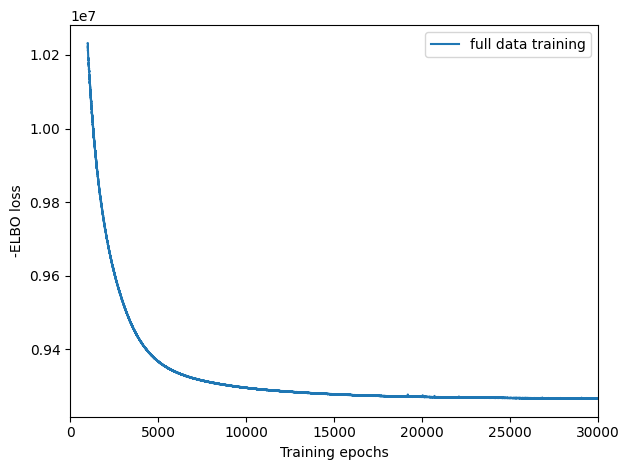

In [51]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
st_model.plot_history(1000)
plt.legend(labels=['full data training']);

### Exporting estimated posterior distributions of cell abundance and saving results:


In [52]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
stadata = st_model.export_posterior(
    stadata, sample_kwargs={'num_samples': 1000, 
                            'batch_size': st_model.adata.n_obs, 
                            'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 64.64it/s]


In [53]:
# Save model
st_model.save(run_name, overwrite=True)

# mod = cell2location.models.Cell2location.load(f"{run_name}", adata_vis)

# Save anndata object with results
adata_file = os.path.join(run_name, "sp.h5ad")
stadata.write(adata_file)
adata_file

'out/deconvolution/cell2location_map/sp.h5ad'

# Analyze results

### Reload model

In [7]:
adata_file = os.path.join(run_name, "sp.h5ad")
stadata = sc.read_h5ad(adata_file)
st_model = cell2location.models.Cell2location.load(run_name, stadata)

INFO     File /lustre/home/hpc/johannes.wirth/data/experiments/SpatialMouse/deconvolution/cel
         l2location/MouseKidneyAtlas/cell2location_map/model.pt already downloaded           
INFO     Preparing underlying module for load                                                


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The number of training samples (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 1/30000:   0%|          | 0/30000 [00:00<?, ?it/s]

/lustre/groups/hpc/meier_lab/.conda/envs/gpu/lib/python3.8/site-packages/torch/distributions/gamma.py:71: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /lustre/groups/hpc/meier_lab/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  self.rate * value - torch.lgamma(self.concentration))


Epoch 1/30000:   0%|          | 1/30000 [00:19<166:22:13, 19.97s/it, v_num=1, elbo_train=1.8e+7]


In [9]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
# this has to be repeated after the reload
stadata = st_model.export_posterior(
    stadata, sample_kwargs={'num_samples': 1000, 
                            'batch_size': st_model.adata.n_obs, 
                            'use_gpu': True}
)

Sampling global variables, sample: 100%|██████████| 999/999 [00:12<00:00, 78.17it/s]


#### Assessing mapping quality

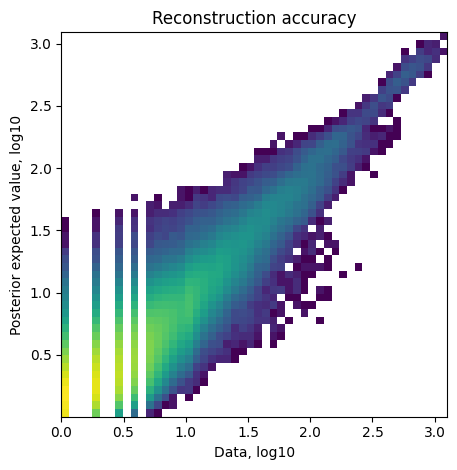

In [10]:
st_model.plot_QC()

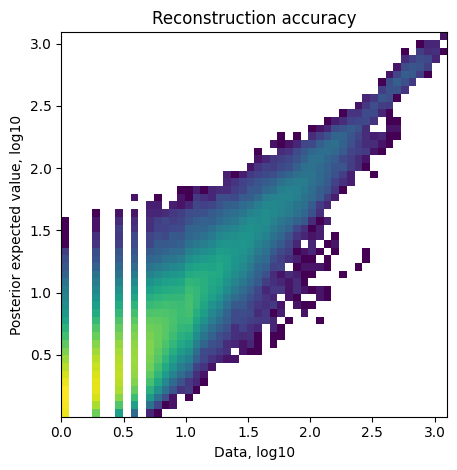

In [76]:
st_model.plot_QC()

## Visualizing cell abundance in spatial coordinates

Note: We use 5% quantile of the posterior distribution, representing the value of cell abundance that the model has high confidence in (aka 'at least this amount is present'). 

In [102]:
rename_dict = {
    "DCT": "Distal convoluted tubules",
    "Early PT": "Early proximal tubules",
    "Endo": "Endothelial cells",
    "IC": "Collecting duct intercalated cells",
    "LOH": "Loop of Henle",
    "Macro": "Macrophages",
    "NP": "Nephron progenitors",
    "Neutro": "Neutrophils",
    "PC": "Collecting duct principal cells",
    "PCT": "Proximal convoluted tubules",
    "PST": "Proximal straight tubules",
    "Podo": "Podocytes",
    "Proliferating": "Proliferating cells",
    "Stroma 1": "Stromal cells 1",
    "Stroma 2": "Stromal cells 2"
}

In [104]:
# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
stadata.uns['mod']['factor_names'] = [rename_dict[elem] if elem in rename_dict else elem for elem in stadata.uns['mod']['factor_names']]
stadata.obs[stadata.uns['mod']['factor_names']] = stadata.obsm['q05_cell_abundance_w_sf']

In [105]:
celltypes = stadata.uns['mod']['factor_names']

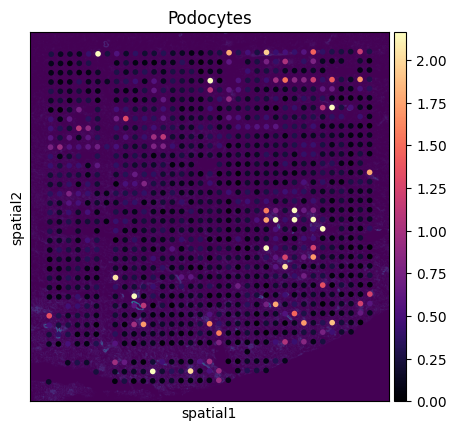

In [107]:
sc.pl.spatial(stadata, cmap='magma', library_id='37_46_B3_phalloidin',
              # show first 8 cell types
              color=['Podocytes'], size=4,
              #ncols=4, size=1.3, 
              #img_key='hires',
              # limit color scale at 99.2% quantile of cell abundance
              vmin=0, vmax='p99.2' 
             )

Saving figure to file figures/deconvolution/spatial_cell2location_celltypes.pdf
Saved.


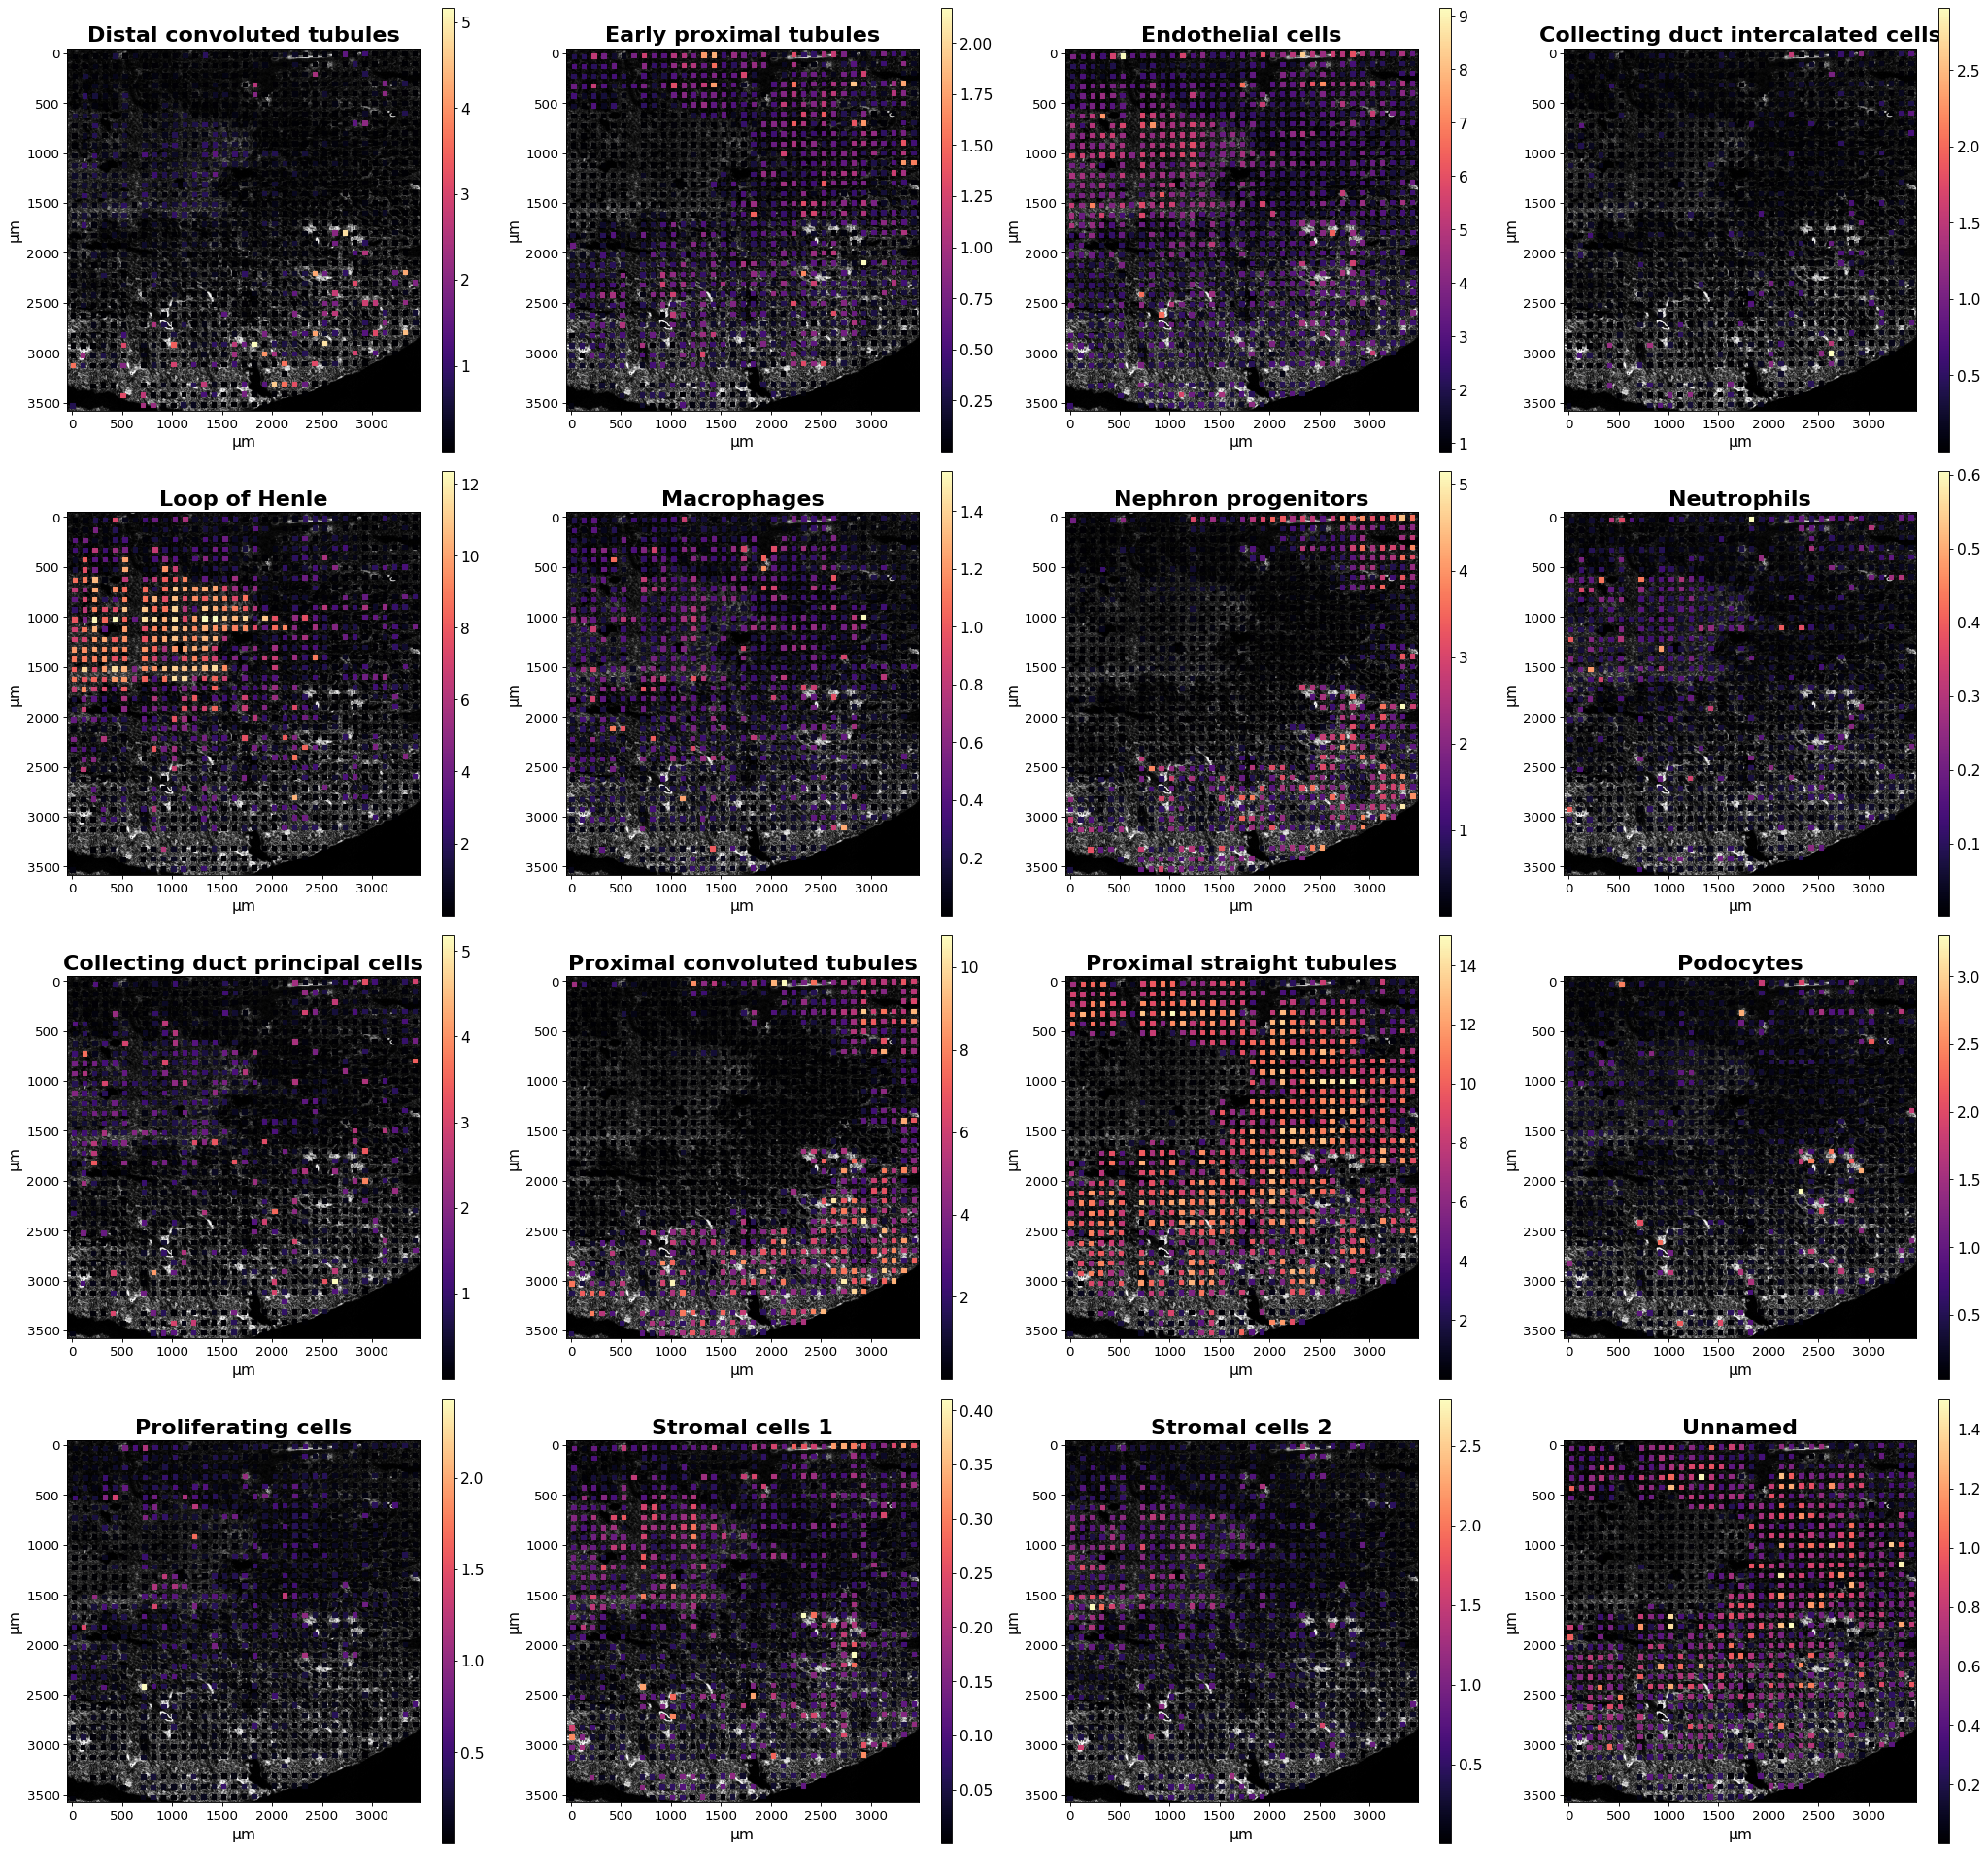

In [127]:
db.pl.spatial(stadata, 
              keys=celltypes, 
              groupby='id',
              image_key='phalloidin',
              cmap='magma', alpha=1, clb_pad=0.05, figsize=(6.5,6),
              savepath="figures/deconvolution/spatial_cell2location_celltypes.pdf"
             )

### Cell type proportions

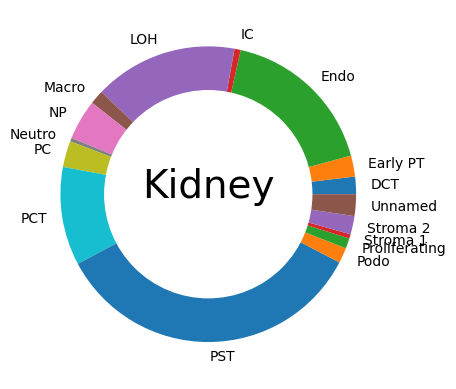

In [21]:
sum_props = stadata.obsm['q05_cell_abundance_w_sf'].sum()
sum_props.index = stadata.uns['mod']['factor_names']
perc = sum_props / sum_props.sum() * 100

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(perc, labels=perc.index, 
        #colors=cm.tab20(np.arange(len(perc)))
       )

p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Kidney", y=0.47, fontsize=28)
plt.savefig("figures/deconvolution/pie_Kidney_cell2location.pdf")
plt.show()

### Rename abbreviations

In [58]:
rename_dict = {
    "DCT": "Distal convoluted tubules",
    "Early PT": "Early proximal tubules",
    "Endo": "Endothelial cells",
    "IC": "Collecting duct intercalated cells",
    "LOH": "Loop of Henle",
    "Macro": "Macrophages",
    "NP": "Nephron progenitors",
    "Neutro": "Neutrophils",
    "PC": "Collecting duct principal cells",
    "PCT": "Proximal convoluted tubules",
    "PST": "Proximal straight tubules",
    "Podo": "Podocytes",
    "Proliferating": "Proliferating cells",
    "Stroma 1": "Stromal cells 1",
    "Stroma 2": "Stromal cells 2"
}

In [62]:
stadata.obsm['q05_cell_abundance_w_sf_renamed'] = stadata.obsm['q05_cell_abundance_w_sf'].copy()
stadata.obsm['q05_cell_abundance_w_sf_renamed'].columns = stadata.uns['mod']['factor_names']
stadata.obsm['q05_cell_abundance_w_sf_renamed'].rename(columns=rename_dict, inplace=True)

In [63]:
stadata.obsm['q05_cell_abundance_w_sf_renamed']

Distal convoluted tubules  Early proximal tubules  \
14x4x37_46_B3                    0.024316                1.144630   
14x3x37_46_B3                    0.121597                0.575258   
14x2x37_46_B3                    0.030680                0.659605   
14x1x37_46_B3                    0.845154                1.712739   
12x15x37_46_B3                   0.248817                0.018887   
...                                   ...                     ...   
18x27x37_46_B3                   0.073489                0.234352   
18x22x37_46_B3                   0.002920                1.003316   
18x21x37_46_B3                   0.039272                0.252997   
18x24x37_46_B3                   0.055035                0.615572   
18x23x37_46_B3                   0.896097                0.302149   

                Endothelial cells  Collecting duct intercalated cells  \
14x4x37_46_B3            2.547978                            0.047486   
14x3x37_46_B3            2.174353                            0.026221   
14x2x37_46_B3            2.513519                            0.043109   
14x1x37_46_B3            4.034226                            0.006084   
12x15x37_46_B3           4.150455                            0.024050   
...                           ...                                 ...   
18x27x37_46_B3           1.223990                            0.001721   
18x22x37_46_B3           1.115503                            0.024527   
18x21x37_46_B3           3.924840                            0.149288   
18x24x37_46_B3           1.969823                            0.067747   
18x23x37_46_B3           3.210192                            0.014515   

                Loop of Henle  Macrophages  Nephron progenitors  Neutrophils  \
14x4x37_46_B3        1.367485     0.071822             0.141330     0.035746   
14x3x37_46_B3        3.046745     0.393310             0.045359     0.019776   
14x2x37_46_B3        1.417074     0.197508             0.535534     0.052869   
14x1x37_46_B3        0.938758     0.147216             1.556284     0.045292   
12x15x37_46_B3       7.666419     0.333102             0.130146     0.112871   
...                       ...          ...                  ...          ...   
18x27x37_46_B3       4.260192     0.028725             1.603964     0.022341   
18x22x37_46_B3       0.132594     0.101801             0.119507     0.008975   
18x21x37_46_B3       1.821250     0.577041             0.045044     0.020720   
18x24x37_46_B3       0.380420     0.072013             0.552831     0.008264   
18x23x37_46_B3       7.689972     0.359941             0.139970     0.063208   

                Collecting duct principal cells  Proximal convoluted tubules  \
14x4x37_46_B3                          0.028371                     0.523491   
14x3x37_46_B3                          0.089243                     0.025168   
14x2x37_46_B3                          0.055311                     2.188698   
14x1x37_46_B3                          0.156879                     4.276396   
12x15x37_46_B3                         0.653802                     0.020976   
...                                         ...                          ...   
18x27x37_46_B3                         0.076442                     2.786304   
18x22x37_46_B3                         0.006530                     0.460637   
18x21x37_46_B3                         0.047220                     0.007928   
18x24x37_46_B3                         0.012545                     2.180457   
18x23x37_46_B3                         0.131738                     0.418580   

                Proximal straight tubules  Podocytes  Proliferating cells  \
14x4x37_46_B3                   12.323746   0.302450             0.324227   
14x3x37_46_B3                    8.782580   0.260843             0.393109   
14x2x37_46_B3                    6.279277   0.100524             0.099953   
14x1x37_46_B3                    5.851793   0.165312             0.038987   
12x

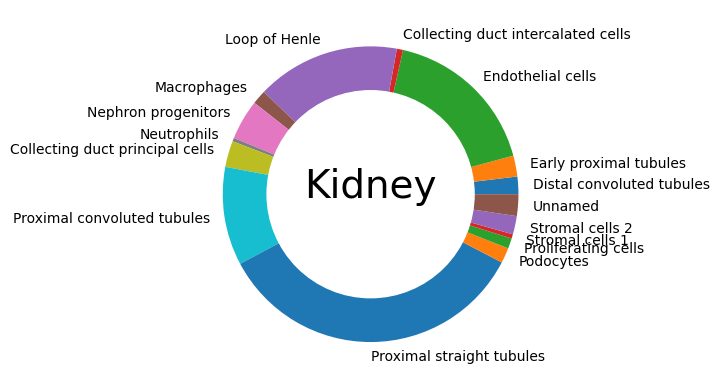

In [64]:
sum_props = stadata.obsm['q05_cell_abundance_w_sf_renamed'].sum()
perc = sum_props / sum_props.sum() * 100

# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

plt.pie(perc, labels=perc.index, 
        #colors=cm.tab20(np.arange(len(perc)))
       )

p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Kidney", y=0.47, fontsize=28)
plt.savefig("figures/deconvolution/pie_Kidney_cell2location_renamed.pdf")
plt.show()